## PolyBERT: Introduction to Chemical Language Models for Fingerprint Generation
By Debasish Mohanty

### Table of Content
1. [Introduction](#intro)
2. [Overview of PSMILES and Fingerprints](#overview)
3. [Understanding PolyBERT Latent Space](#polybertlspace)
4. [Implementing PolyBERT using HuggingFace](#hfimplement)
5. [Similarity Predictions Using Fingerprint](#similarpred)
6. [Summary](#sum)
7. [Reference](#ref)

### 1. Introduction <a id="intro"></a>

This article introduces PolyBERT, an innovative machine learning approach to polymer informatics inspired by natural language processing techniques. PolyBERT enables researchers to efficiently and accurately search for optimal polymer candidates within this vast chemical space. By employing fingerprints PolyBERT translates polymer chemical structures into a machine-interpretable vector.
The PolyBERT can have various applications from chem-informatics to multitask property predictions. It can be employed in different pipelines to generate or predict relevant polymer molecules and properties as shown in Figure -1.

![polybert_intro](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41467-023-39868-6/MediaObjects/41467_2023_39868_Fig1_HTML.png?as=webp)

**Figure - 1 :** The pipelines and applications of PolyBERT `[1]`

### 2. Overview of PSMILES and Fingerprints <a id="overview"></a>

Polymer SMILES (PSMILES) `[1]` is an extension of the Simplified Molecular Input Line Entry System (SMILES) notation, specifically designed to represent polymer structures. While traditional SMILES is used for small organic molecules, PSMILES accounts for the repeating units characteristic of polymers. This notation uses the wildcard `[*]` to indicate the points where the polymer chain extends, enabling the representation of large macromolecules in a concise and machine-readable format.

Key Features of PSMILES:
- **Repeating Units**: PSMILES captures the repeating units in a polymer, essential for understanding polymer behavior and properties.
- **Wildcard Symbol `[*]`**: Marks the connection points of the polymer's repeating unit.
- **Computational Use**: Facilitates the analysis, storage, and sharing of polymer data in cheminformatics and materials science.

PSMILES provides a standardized way to describe polymers, making it easier to perform computational studies and design new materials with specific properties.

Chemical fingerprints are binary or integer vectors that represent the presence or absence of specific substructures or patterns within a molecule. These fingerprints serve as molecular descriptors, summarizing a molecule’s structure in a format that is suitable for computational tasks such as similarity searches, clustering, and machine learning applications.

Key Features of Chemical Fingerprints:

- **Similarity Search:** Identifying compounds with similar structures.
- **Clustering and Classification:** Grouping molecules based on structural similarities.
- **Machine Learning:** Used as input features in predictive models for drug discovery and materials science.

Chemical fingerprints are powerful tools for transforming molecular structures into data that can be efficiently processed and analyzed, making them essential in modern cheminformatics.

PSMILES are beneficial for streamlined data processing and sequential machine learning models, whereas fingerprints provide a wide range of scientific utilities, from searching for similar molecules to facilitating material discovery. In this tutorial, we have demonstrated how to generate equivalent fingerprints (using transformer latent space) from PSMILES string representations.

### 3. PolyBERT Latent Space <a id="polybertlspace"></a>

Latent space refers to a lower-dimensional representation of data, where complex information is encoded in a more compact form. In the context of transformers, latent space is where the model captures essential features and patterns of input data, like PSMILES strings, after processing through several layers. This space allows the model to focus on important relationships and characteristics that are useful for tasks like predicting properties, clustering, or generating new data.

[PolyBERT](https://www.nature.com/articles/s41467-023-39868-6) `[1]` is a chemical language model developed upon DeBERTa architecture. [DeBERTa](https://arxiv.org/abs/2006.03654) (Decoding-enhanced BERT with Disentangled Attention)`[2]` is an advanced transformer architecture that improves how information is processed. Unlike standard transformers, DeBERTa disentangles the position of words (or atoms in a molecule) and their content, leading to more accurate representations. When PolyBERT uses the DeBERTa architecture, it leverages these improvements to better understand and generate the latent space for polymers, making it more effective in tasks like generating chemical fingerprints or predicting molecular properties.

PolyBERT leverages the latent space of the DeBERTa architecture to attain the functionalities of fingerprints. PolyBERT specifically uses fingerprint of **600** dimensions making the prediction and clustering tasks highly accurate. Once implemented, the fingerprints can be mapped with properties of the polymers to do multi-task predictions.

### 4. Implementing PolyBERT using HuggingFace <a id="hfimplement"></a>

The tokenizer and the model weights of the PolyBERT can be found in [HuggingFace](https://huggingface.co/kuelumbus/polyBERT) model repository. For our case we will take two PSMILES i.e. PolyEthylene (PE) and PolyVinylAlcohol(PVA) represented as `[*]CC[*]`, `[*]COC[*]` respectively. We will use PolyBERT to generate fingerprints for both PSMILES using following steps.

1. Load the tokenizer and model weights for PolyBERT
2. Tokenize the PSMILES and generate the fingerprint
3. Performing the mean-pooling (to normalize the fingerprint value)


#### Imports

In [2]:
! pip install rdkit-pypi transformers
from transformers import AutoTokenizer, AutoModel
import torch
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

#### Visualizing Polymers

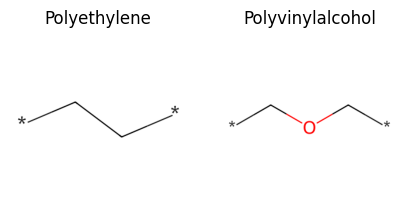

In [3]:
smiles_list = ["[*]CC[*]", "[*]COC[*]"]
mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

def show_mols(mols: list, labels: list, figsize=(5,5)):
    """
    This function is used to display a list of molecules using matplotlib.
    """
    if len(mols) > 1:
        fig, ax = plt.subplots(1, len(mols), figsize=figsize)
        for i in range(len(mols)):
            mol = mols[i]
            label = labels[i]
            img = Draw.MolToImage(mol)
            ax[i].imshow(img)
            ax[i].set_title(label)
            ax[i].axis('off')
            ax[i].set_aspect('equal')
    else:
        mol = mols[0]
        label = labels[0]
        img = Draw.MolToImage(mol)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()


show_mols(mol_list, ["Polyethylene", "Polyvinylalcohol"])


#### Generating Fingerprints

Initially, we will load tokenizer and model weights for PolyBERT using HuggingFace transformer library.

In [7]:
# Step - 0: Load the tokenizer and model weights for PolyBERT

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('kuelumbus/polyBERT')
polyBERT = AutoModel.from_pretrained('kuelumbus/polyBERT')

d:\own\career\open_source\env_files\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Once initialized, we can define our PSMILES string and make the finger print predictions as follows.

In [13]:
# Step - 2: Tokenize the PSMILES and generate the fingerprint
# Sentences we want sentence embeddings for
psmiles_strings = ["[*]CC[*]", "[*]COC[*]"]

# Tokenize sentences
encoded_input = tokenizer(psmiles_strings, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = polyBERT(**encoded_input)
    print("model output >>", model_output)
    print("output shape >>", model_output.last_hidden_state.shape)

model output >> BaseModelOutput(last_hidden_state=tensor([[[-0.3600, -0.1442, -0.9196,  ..., -0.5034,  0.5028,  1.2998],
         [-0.3190,  0.0676, -0.9040,  ..., -0.3021,  0.5724,  1.2594],
         [-0.0568, -0.4151,  0.0570,  ..., -0.3222,  0.4901,  1.7791],
         ...,
         [ 0.0989,  0.1656, -0.0327,  ..., -0.3214, -0.0025,  0.6070],
         [-0.2276,  0.3628, -0.5948,  ..., -0.8587,  0.1078,  0.0966],
         [ 0.2695,  0.6533,  0.5087,  ..., -0.1991, -0.1496,  0.5560]],

        [[-0.4281,  0.6151, -0.6989,  ..., -0.4487,  0.4334,  1.0624],
         [-0.4327,  0.7250, -0.7236,  ..., -0.4047,  0.4732,  1.0544],
         [-0.3124,  0.1882,  0.1288,  ..., -0.6645,  0.2649,  1.5900],
         ...,
         [ 0.0755,  0.8277, -0.1443,  ..., -0.1048,  0.1284,  0.3646],
         [-0.3230,  1.1286,  0.3890,  ..., -0.7890,  0.2660,  1.9148],
         [-0.3051,  0.0756,  0.1737,  ..., -0.8654, -0.0336,  0.7049]]]), hidden_states=None, attentions=None)
output shape >> torch.Size([

The model output is 3 dimensional, while the fingerprint has to be of shape `1 X 600`. The first array in the output contains all the token embedding. To normalize the output, we will clip the values same as the Attention Mask. Then we will form a finalized vector by find mean of 8 token embedding layers ( as the shape is `2 X 8 X 600`). This process is called Mean Pooling. The same has been implemented as follows.

In [4]:

# Step - 3: Performing the mean-pooling (to normalize the fingerprint value)

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Perform pooling. In this case, mean pooling.
fingerprints = mean_pooling(model_output, encoded_input['attention_mask'])

print("Fingerprints:")
print(fingerprints)


d:\own\career\open_source\env_files\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USERNAME\.cache\huggingface\hub\models--kuelumbus--polyBERT. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
d:\own\career\open_source\env_files\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureW

Fingerprints:
tensor([[-0.1186,  0.1891, -0.5370,  ..., -0.8715,  0.2979,  0.6712],
        [-0.3981,  0.4833, -0.2797,  ..., -0.5428,  0.2027,  0.9449]])


We can notice two-dimensional tensors that hold the fingerprint for each polymer. Let's vailidate the dimension if those have the required dimension as specified.

In [5]:
for f in fingerprints:
    print(f.shape)

torch.Size([600])
torch.Size([600])


As per the above output, we can see dimension is `1 X 600` same as mentioned in section 3. Now we can use these vector to predict similarity between 2 polymers.

### 5. Similarity Predictions Using Fingerprint <a id="similarpred"></a>

There are various algorithms to find similarity between different high dimensional vectors. We will be using **cosine similarity** for our use case.Cosine similarity is a measure of how similar two vectors are, regardless of their size. Imagine each vector as an arrow pointing in space. Cosine similarity compares the angle between these arrows, not their length. If the angle is small (close to 0°), the vectors are similar; if the angle is large (close to 90°), they are less similar. We can visualize the same using following image.

![similarity](https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.original.jpg)


In simple terms, cosine similarity tells us how much two items "point" in the same direction, making it useful for comparing things like text documents or molecular fingerprints where exact values matter less than overall patterns.

In [6]:
import torch.nn.functional as F
# Compute cosine similarity between the first and second fingerprint
cosine_sim = F.cosine_similarity(fingerprints[0].unsqueeze(0), fingerprints[1].unsqueeze(0))

print(f"\nCosine Similarity between fingerprints: '{psmiles_strings[0]}' and '{psmiles_strings[1]}' is ")
print(cosine_sim.item())


Cosine Similarity between fingerprints: '[*]CC[*]' and '[*]COC[*]' is 
0.8462606072425842


By determining the cosine similarity of the fingerprint vectors, we found that polyethylene `([*]CC[*])` is similar to polyvinylalcohol `([*]COC[*])` by 85%.

### 6. Summary <a id="sum"></a>

The tutorial provides an in-depth exploration of PolyBERT, a state-of-the-art machine learning model designed to advance polymer informatics by leveraging natural language processing techniques. PolyBERT enables efficient and precise exploration of the vast chemical space of polymers, facilitating the identification of materials with specific properties. The model uses transformers latent space to convert polymer chemical structures into machine-readable vectors, known as fingerprints, which are crucial for various computational tasks.

Key sections of the article include:

1. **Introduction:** The introduction outlines the challenges in polymer discovery and introduces PolyBERT as a novel solution, highlighting its applications in cheminformatics and multi-task property prediction.

2. **Overview of PSMILES and Fingerprints:** This section discusses Polymer SMILES (PSMILES), a specialized notation for representing polymer structures, and chemical fingerprints, which are essential for tasks like similarity searches and machine learning.

3. **Understanding PolyBERT Latent Space:** PolyBERT's latent space, based on the DeBERTa architecture, is explained as a lower-dimensional representation that captures the essential features of polymer structures. This space is crucial for generating accurate fingerprints and performing prediction tasks.

4. **Implementing PolyBERT Using HuggingFace:** The implementation section guides readers through using the HuggingFace library to generate fingerprints for polymers, using specific PSMILES strings as examples.

5. **Similarity Predictions Using Fingerprint:** The article demonstrates how to compute cosine similarity between fingerprint vectors, illustrating how PolyBERT can assess the similarity between different polymers.

By combining the advanced capabilities of transformer models with the unique challenges of polymer informatics, PolyBERT represents a significant leap forward in the field, offering scalable solutions for material discovery and prediction.

### 7. Reference <a id="ref"></a>

1. [Kuenneth, Christopher, and Rampi Ramprasad. "polyBERT: a chemical language model to enable fully machine-driven ultrafast polymer informatics." Nature Communications 14.1 (2023): 4099.](https://www.nature.com/articles/s41467-023-39868-6)
2. [He, Pengcheng, et al. "Deberta: Decoding-enhanced bert with disentangled attention." arXiv preprint arXiv:2006.03654 (2020).](https://arxiv.org/abs/2006.03654)

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Citing This Tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX.

In [ ]:
@manual{Intro1,
 title={PolyBERT: Introduction to Chemical Language Models for Fingerprint Generation},
 organization={DeepChem},
 author={Mohanty, Debasish},
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/PolyBERT___Introduction_to_Chemical_Language_Models_for_Fingerprint_Generation.ipynb}},
 year={2024},
}